In [1]:
# !apt-get update && apt-get install libsm6 libxext6 -y -qq
# !apt-get install libgl1-mesa-glx graphviz -y -qq
# !pip install -r requirements.txt
# import os
# os._exit(0)
# # # !apt-get install unrar

# IMPORT PACKAGES

In [1]:
import os
import shutil
import PIL
import numpy as np
import cv2
import zipfile
from PIL import Image
import tensorflow as tf
import pandas as pd
import pathlib
import natsort
import sys
import math
import random
import albumentations as A

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
%load_ext autotime

print(tf.__version__)
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

2024-12-02 15:21:03.852365: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 15:21:03.852419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 15:21:03.853612: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 15:21:03.859593: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 15:21:04.582160: W tensorflow/compiler/tf2

2.15.0
time: 474 µs (started: 2024-12-02 15:21:06 +00:00)


In [2]:
EPOCHS = 2000
BATCH = 4
ETA = 0.001
WEIGHT_DECAY = 6e-8
IMAGE_SHAPE = (512, 1024, 1)
MASK_SHAPE = (512, 1024, 1)
model_path = './models'
plot_path = './chart'

time: 357 µs (started: 2024-12-02 15:21:06 +00:00)


In [3]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     # Enable GPU memory growth (optional)
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)
    # Set mixed precision policy
    # policy = tf.keras.mixed_precision.Policy('mixed_float16')
    # tf.keras.mixed_precision.set_global_policy(policy)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow GPU device: ", tf.test.gpu_device_name())
print("All devices: ", tf.config.list_physical_devices())

Num GPUs Available:  1
TensorFlow GPU device:  /device:GPU:0
All devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
time: 1.19 s (started: 2024-12-02 15:21:06 +00:00)


2024-12-02 15:21:06.798010: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-02 15:21:06.894207: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-02 15:21:06.894387: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# READ DATASET (IMAGES, MASKS)

In [ ]:
#custom augmentation that simulate random light appears in vertical block of ct-scan results
class VerticalBrightnessBlock(A.ImageOnlyTransform):
    def __init__(self, block_width=(10, 50), intensity=(200, 255), always_apply=False, p=0.5):
        super(VerticalBrightnessBlock, self).__init__(always_apply=always_apply, p=p)
        self.block_width = block_width
        self.intensity = intensity

    def apply(self, img, **params):
        img = img.copy()
        h, w = img.shape[:2]
        # Random block width
        block_w = random.randint(self.block_width[0], self.block_width[1])
        # Random block position
        start_x = random.randint(0, w - block_w)
        # Random brightness intensity
        intensity_value = random.randint(self.intensity[0], self.intensity[1])
        # Add the vertical block
        img[:, start_x:start_x + block_w] = np.clip(img[:, start_x:start_x + block_w] + intensity_value, 0, 255)
        return img

time: 726 µs (started: 2024-12-02 15:34:55 +00:00)


In [30]:
class readDataset:
    def __init__(self, imagesPathes, masksPathes):
        self.imagesPathes = imagesPathes
        self.masksPathes = masksPathes
        self.images = None
        self.masks = None
        self.val_images = None
        self.val_masks = None
        self.test_images = None
        self.test_masks = None
        
    def readPathes(self,):
        self.images = natsort.natsorted(list(pathlib.Path(self.imagesPathes).glob('*.*')))
        self.masks = natsort.natsorted(list(pathlib.Path(self.masksPathes).glob('*.*')))
        try:
            shutil.rmtree(os.path.join(self.imagesPathes, ".ipynb_checkpoints"))
            shutil.rmtree(os.path.join(self.masksPathes, ".ipynb_checkpoints"))
            print(f".ipynb_checkpoints directory deleted successfully.")
        except Exception as e:
            print(f"just checking .ipynb_checkpoints (nothing)")
        
    def readImages(self, data, typeData):
        images = []
        height = 512
        width =  1024
        for img in data:
            img_name = img.name
            img = cv2.imread(str(img), 0)
            img = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)
            if typeData == 'm':
                img = np.where(img > 0, 1, 0)
            img = np.expand_dims(img, axis=-1)
            images.append(img)
        print("(INFO..) Read Image Done")
        return np.array(images)

    def normalizeImages(self, images):
        normalized_images = []
        clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(3,3))
        for img in images:
            img = img.astype(np.uint8)
            img = clahe.apply(img)
            img = np.expand_dims(img, axis=-1)
            img = img / 255.
            normalized_images.append(img)
        print("(INFO..) Normalization Image Done")
        return np.array(normalized_images)
            
    def dataAugmentation(self, images, masks):
        augmentation = A.ReplayCompose([
            A.HorizontalFlip(p=0.5),
            # Vertical Translation
            A.ShiftScaleRotate(
                shift_limit_x=0,
                shift_limit_y=(-0.1, 0.05),
                scale_limit=(-0.05, 0.05), 
                rotate_limit=0,
                interpolation=cv2.INTER_AREA,
                mask_interpolation=cv2.INTER_AREA,
                border_mode=cv2.BORDER_CONSTANT,
                p=0.5,
            ),
            A.RandomGamma(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=(-0.25, 0.4),
                                       contrast_limit=(-0.25, 0.35),
                                       p=0.5),
            A.ElasticTransform(alpha=10, 
                               sigma=10, 
                               interpolation=cv2.INTER_AREA,
                               mask_interpolation=cv2.INTER_AREA,
                               p=0.2)
        ], bbox_params=None)
        
        if len(images) != len(masks):
            raise ValueError("Number of images and masks must be the same.")

        augmented_images = []
        augmented_masks = []

        for image, mask in zip(images, masks):
            # Original image and mask
            augmented_images.append(image)
            augmented_masks.append(mask)
            
            image = image.astype(np.uint8)
            mask = mask.astype(np.uint8)
            
            # Perform augmentations
            # Generate 6 augmented versions per image
            for _ in range(5):                
                # Handle single-channel images
                if len(image.shape) == 2:
                    image = np.expand_dims(image, axis=-1)
                if len(mask.shape) == 2:
                    mask = np.expand_dims(mask, axis=-1)

                # Apply augmentation
                augmented = augmentation(image=image, mask=mask)
                
                augmented_images.append(augmented['image'])
                augmented_masks.append(augmented['mask'])
                
        print("(INFO..) Augmentation Image Done")
        return np.array(augmented_images), np.array(augmented_masks)
        
    
    def splitDataset(self, images, masks, val_size=20, test_size=10, random_state=42):
        data = list(zip(images, masks))
        train_data, test_data = train_test_split(data, test_size=(val_size + test_size), random_state=random_state)
        val_data, test_data = train_test_split(test_data, test_size=(test_size / (val_size + test_size)), random_state=random_state)

        train_images, train_masks = zip(*train_data)
        val_images, val_masks = zip(*val_data)
        test_images, test_masks = zip(*test_data)
        
        # Augment train data
        train_images_aug, train_masks_aug = self.dataAugmentation(np.array(train_images), np.array(train_masks))
        
        print("(INFO..) Splitting and Saving Data Done")
        return (np.array(train_images_aug), np.array(train_masks_aug), 
                np.array(val_images), np.array(val_masks), 
                np.array(test_images), np.array(test_masks))


images_path = './dataset/images'
masks_path = './dataset/masks'
    
dataset = readDataset(images_path, masks_path)
dataset.readPathes()
    
# Read images
images = dataset.readImages(dataset.images, 'i')
masks = dataset.readImages(dataset.masks, 'm')
    
# Split and augment dataset
trainImages, trainMasks, validImages, validMasks, testImages, testMasks = dataset.splitDataset(images, masks)

trainImages = dataset.normalizeImages(trainImages)
validImages = dataset.normalizeImages(validImages)
testImages = dataset.normalizeImages(testImages)

just checking .ipynb_checkpoints (nothing)
(INFO..) Read Image Done
(INFO..) Read Image Done
(INFO..) Augmentation Image Done
(INFO..) Splitting and Saving Data Done
(INFO..) Normalization Image Done
(INFO..) Normalization Image Done
(INFO..) Normalization Image Done
time: 34.8 s (started: 2024-12-02 15:46:15 +00:00)


In [31]:
print(f"Data Train: {trainImages.shape}, {trainMasks.shape}")
print(f"Data Validation: {validImages.shape}, {validMasks.shape}")
print(f"Data Test: {testImages.shape}, {testMasks.shape}")

Data Train: (978, 512, 1024, 1), (978, 512, 1024, 1)
Data Validation: (20, 512, 1024, 1), (20, 512, 1024, 1)
Data Test: (10, 512, 1024, 1), (10, 512, 1024, 1)
time: 477 µs (started: 2024-12-02 15:46:50 +00:00)


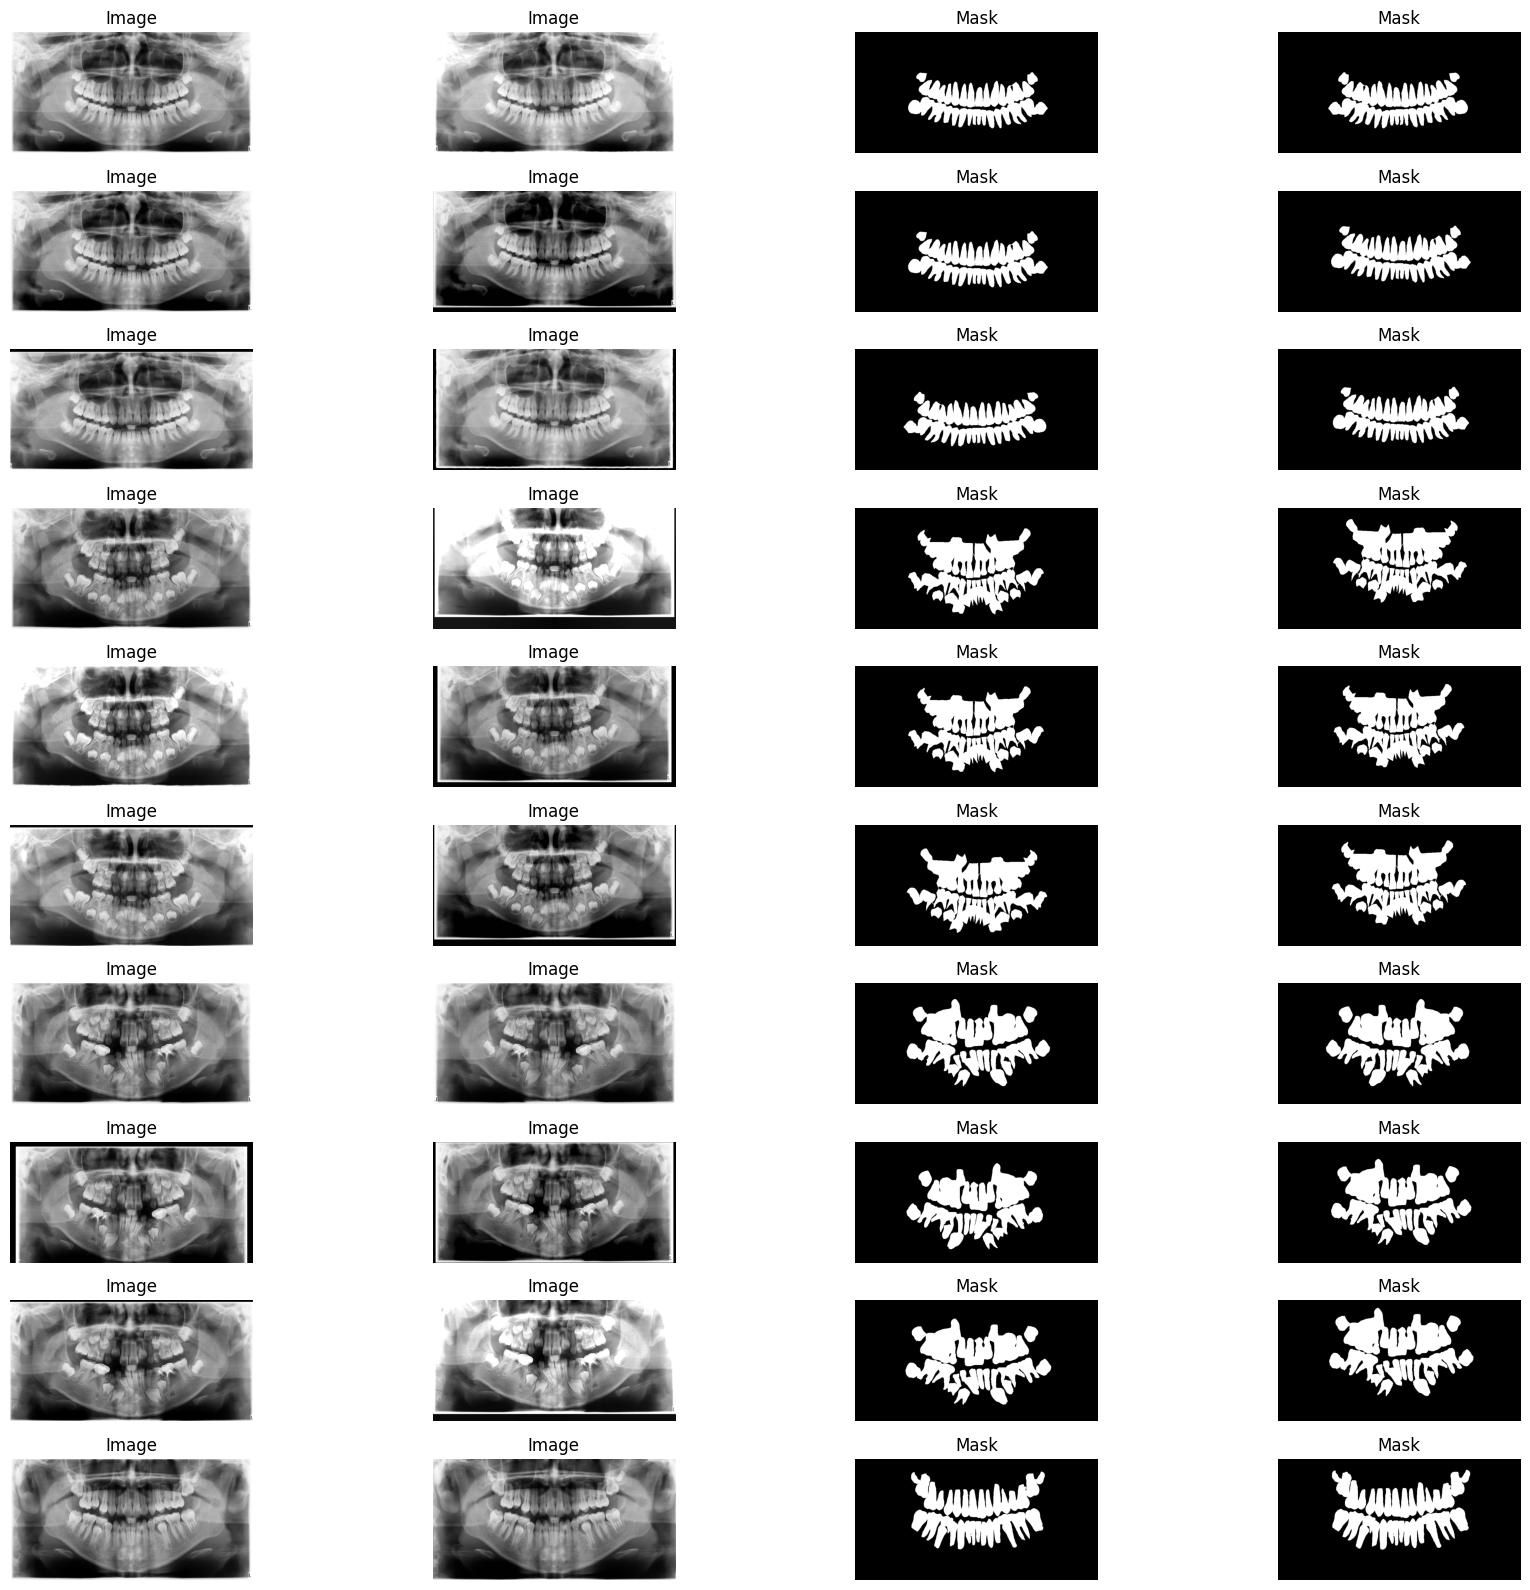

time: 2.75 s (started: 2024-12-02 15:46:50 +00:00)


In [32]:
plt.figure(figsize=(18, 16))
gs = gridspec.GridSpec(20 // 2, 4, width_ratios=[1, 1, 1, 1])
for i in range(20):
    ax0 = plt.subplot(gs[i // 2, i % 2])
    ax1 = plt.subplot(gs[i // 2, i % 2 + 2])
    ax0.imshow(trainImages[i], cmap='gray', aspect='auto')
    ax1.imshow(trainMasks[i], cmap='gray', aspect='auto')
    ax0.set_title('Image')
    ax1.set_title('Mask')
    ax0.axis('off')
    ax1.axis('off')
    ax0.set_aspect('equal')
    ax1.set_aspect('equal')
plt.tight_layout()
plt.show()

# Define Dice Loss

In [33]:
def dice_score(y_true, y_pred, threshold=0.5):
    smooth = 1.
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), dtype=tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred >= threshold, [-1]), dtype=tf.float32)
    intersection = y_true_f * y_pred_f
    score = (2. * tf.reduce_sum(intersection) + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1. - dice_score(y_true, y_pred)
    return tf.cast(loss, dtype=tf.float32)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return tf.cast(bce, dtype=tf.float32) + dice

def bfce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryFocalCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return tf.cast(bce, dtype=tf.float32) + dice

def binaryIoU_loss(y_true, y_pred):
    IoU =  tf.keras.metrics.BinaryIoU()(y_true, y_pred)
    return 1 - IoU

time: 908 µs (started: 2024-12-02 15:48:48 +00:00)


# Proposing a generative neural network architecture

In [34]:
def convolution(input, filter, padding, strides, kernel, activation, conv_type, name_prefix=''):
    initializer = tf.random_normal_initializer(0., 0.02)
    x = input
    x = layers.Conv2D(filter, kernel_size=kernel, padding=padding, strides=strides, 
                      kernel_initializer=initializer, use_bias=False, name=f'{name_prefix}_conv1')(x)
    x = layers.GroupNormalization(groups=filter, name=f'{name_prefix}_gn1')(x)
    
    if conv_type == 'decoder':
        x = layers.Activation(activation, name=f'{name_prefix}_activation1')(x)
        x = layers.Conv2D(filter*2, kernel_size=kernel, padding=padding, strides=strides, 
                          kernel_initializer=initializer, use_bias=False, name=f'{name_prefix}_conv2')(x)
        x = layers.GroupNormalization(groups=filter*2, name=f'{name_prefix}_gn2')(x)
        x = layers.Activation(activation, name=f'{name_prefix}_activation2')(x)
        x = layers.Conv2D(filter, kernel_size=kernel, padding=padding, strides=strides, 
                          kernel_initializer=initializer, use_bias=False, name=f'{name_prefix}_conv3')(x)
        x = layers.GroupNormalization(groups=filter, name=f'{name_prefix}_gn3')(x)
    
    x = layers.average([x, layers.Conv2D(filter, kernel_size=1, padding='same', strides=1, kernel_initializer=initializer, name=f'{name_prefix}_conv4')(input)], name=f'{name_prefix}_residual_connection')
    x = layers.Activation(activation, name=f'{name_prefix}_rescon_activation')(x)
    return x

time: 934 µs (started: 2024-12-02 15:48:49 +00:00)


In [35]:
def encoder(input, filter, padding, strides, kernel, activation, name_prefix):
    x = input
    x = convolution(x, filter, padding, strides, kernel, activation, 'encoder', name_prefix=name_prefix)
    downsample = layers.AveragePooling2D(pool_size=(2, 2), name=f'{name_prefix}_pool')(x)
    return downsample, x

time: 433 µs (started: 2024-12-02 15:48:50 +00:00)


In [36]:
def decoder(input, filter, skip, padding, strides, kernel, activation, name_prefix, dropout=False):
    x = input
    initializer = tf.random_normal_initializer(0., 0.02)
    x = layers.Conv2DTranspose(filter, padding = padding, kernel_size = kernel,
                               activation=activation, strides = 2, kernel_initializer=initializer,
                               use_bias=False, name=f'{name_prefix}_transpose')(x)
    
    if dropout:
        x = layers.Dropout(0.5, name=f'{name_prefix}_dropout')(x)
    x = layers.average([x, skip], name=f'{name_prefix}_skip_connection')
    x = convolution(x, filter, padding, strides, kernel, activation, 'decoder', name_prefix=name_prefix)
    return x

time: 591 µs (started: 2024-12-02 15:48:50 +00:00)


In [37]:
def bottleneck(input, filters_bottleneck, strides, kernel, activation, depth=6, mode='cascade', name_prefix=''):
    dilated_layers = []
    x = input
    if mode == 'cascade':
        for i in range(depth):
            residual = x
            x = layers.Conv2D(filters_bottleneck, kernel_size=kernel, strides=strides,
                               activation=activation, padding='same', dilation_rate=2**i,
                              kernel_initializer=tf.random_normal_initializer(0., 0.02), name=f'{name_prefix}_conv_{i+1}')(x)
            dilated_layers.append(x)
        x = layers.add(dilated_layers, name=f'{name_prefix}_dilated_layers')
        x = layers.GroupNormalization(groups=filters_bottleneck, name=f'{name_prefix}_gn')(x)
        return x
    
    elif mode == 'cascade_residual':
        for i in range(depth):
            residual = x  # Save the input for the residual connection
            x = layers.Conv2D(filters_bottleneck, kernel_size=kernel, strides=strides,
                              activation=activation, padding='same', dilation_rate=2**i,
                              kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
            dilated_layers.append(x)
            if i % 2 == 0:  # Add residual connection only on even convolutional layers
                # Add a 1x1 convolution to the residual connection to match shapes
                residual = layers.Conv2D(filters_bottleneck, kernel_size=(1, 1), strides=strides,
                                         padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))(residual)
                residual = layers.GroupNormalization(groups=filters_bottleneck)(residual)
                # Add the residual connection
                x = layers.add([x, residual])
            
        cascade_layer = layers.add(dilated_layers)
        fusion = layers.add([cascade_layer, x])
        fusion = layers.GroupNormalization(groups=filters_bottleneck)(fusion)
        return fusion
    
    elif mode == 'cascade_residual_multidimension':
        for i in range(depth):
            residual = x 
            x = layers.Conv2D(filters_bottleneck, kernel_size=kernel, strides=strides,
                               activation=activation, padding='same', dilation_rate=2**i,
                              kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
            dilated_layers.append(x)
            residual = layers.Conv2D(filters_bottleneck, kernel_size=(1, 1), strides=strides,
                                     padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))(residual)
            residual = layers.GroupNormalization(groups=filters_bottleneck)(residual)
            x = layers.add([x, residual])
            dilated_layers.append(x)
        fusion = layers.add(dilated_layers)
        fusion = layers.GroupNormalization(groups=filters_bottleneck)(fusion)
        return fusion
    
    elif mode == 'parallel':  # Like "Atrous Spatial Pyramid Pooling"
        for i in range(depth):
            dilated_layers.append(
                layers.Conv2D(filters_bottleneck, kernel_size=kernel,
                       activation=activation, padding='same', dilation_rate=2**i)(x)
            )
        parallel = layers.add(dilated_layers) 
        parallel = layers.GroupNormalization(groups=filters_bottleneck)(parallel)
        return parallel

time: 2.25 ms (started: 2024-12-02 15:48:51 +00:00)


In [38]:
def generator(input, filter, padding, strides, kernel, model_weights=None, weights_path=''):
    x = input
    con1, skip1 = encoder(x, filter, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='encoder1')
    con2, skip2 = encoder(con1, filter*2, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='encoder2')
    con3, skip3 = encoder(con2, filter*4, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='encoder3')
    con4, skip4 = encoder(con3, filter*8, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='encoder4')
    con5, skip5 = encoder(con4, filter*16, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='encoder5')
    deco1 = decoder(con5, filter*16, skip5, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(0.2), name_prefix='decoder1')
    deco2 = decoder(deco1, filter*8, skip4, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(0.2), name_prefix='decoder2')
    deco3 = decoder(deco2, filter*4, skip3, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(0.2), name_prefix='decoder3')
    deco4 = decoder(deco3, filter*2, skip2, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(0.2), name_prefix='decoder4')
    deco5 = decoder(deco4, filter, skip1, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(0.2), name_prefix='decoder5')
    
    initializer = tf.random_normal_initializer(0., 0.02)
    output = layers.Conv2DTranspose(1, kernel_size=kernel, strides=strides, padding=padding, 
                                    kernel_initializer=initializer, activation='sigmoid', 
                                    name='generator_output_layer')(deco5)
    
    generator = models.Model(inputs=input, outputs=output, name='generator')
    
    if model_weights and weights_path:
        generator.load_weights(weights_path)
    generator.summary()
    return generator

time: 1.07 ms (started: 2024-12-02 15:48:53 +00:00)


In [14]:
generator = generator(input=layers.Input(shape = IMAGE_SHAPE), filter=32, padding='same', kernel=3, strides=1, 
                            model_weights=None, 
                            weights_path="")

2024-12-02 12:29:48.739137: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-02 12:29:48.739359: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-02 12:29:48.739449: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 1024, 1)]       0         []                            
                                                                                                  
 encoder1_conv1 (Conv2D)     (None, 512, 1024, 32)        288       ['input_1[0][0]']             
                                                                                                  
 encoder1_gn1 (GroupNormali  (None, 512, 1024, 32)        64        ['encoder1_conv1[0][0]']      
 zation)                                                                                          
                                                                                                  
 encoder1_conv4 (Conv2D)     (None, 512, 1024, 32)        64        ['input_1[0][0]']     

In [15]:
# tf.keras.utils.plot_model(generator, show_shapes = True, show_layer_names=True, to_file='./chart/generator.png')

time: 199 µs (started: 2024-12-02 12:29:50 +00:00)


In [16]:
def discriminator(ImageInput, maskInput, filter, padding, strides, kernel, lossFn, learning_rate, weight_decay, model_weights, weights_path=''):
    x = layers.multiply([ImageInput, maskInput])
    con1, skip1 = encoder(x, filter, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='disc_encoder1')
    con2, skip2 = encoder(con1, filter*2, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='disc_encoder2')
    con3, skip3 = encoder(con2, filter*4, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='disc_encoder3')
    con4, skip4 = encoder(con3, filter*8, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='disc_encoder4')
    con5, skip5 = encoder(con4, filter*16, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='disc_encoder5')
    x = layers.GlobalAveragePooling2D()(con5)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(1)(x)
    discriminator = models.Model(inputs=[maskInput, ImageInput], outputs=x, name='discriminator')
    if model_weights is not None:
        discriminator.load_weights(weights_path)
    discriminator.compile(loss=lossFn, loss_weights=[1],
                          optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, weight_decay=weight_decay),)
    discriminator.summary()
    return discriminator

time: 1.4 ms (started: 2024-12-02 12:29:50 +00:00)


In [17]:
discriminator = discriminator(ImageInput=layers.Input(shape=IMAGE_SHAPE), 
                                    maskInput=layers.Input(shape=MASK_SHAPE),
                                    filter=32, padding = 'same', strides=1, kernel=3, 
                                    lossFn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                                    learning_rate=ETA, weight_decay=WEIGHT_DECAY,
                                    model_weights=None,
                                    weights_path="")

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 1024, 1)]       0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 512, 1024, 1)]       0         []                            
                                                                                                  
 multiply (Multiply)         (None, 512, 1024, 1)         0         ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 disc_encoder1_conv1 (Conv2  (None, 512, 1024, 32)        288       ['multiply[0][0]']

In [18]:
# tf.keras.utils.plot_model(discriminator, show_shapes = True, show_layer_names=True, to_file='./chart/discriminator.png')

time: 199 µs (started: 2024-12-02 12:29:50 +00:00)


In [19]:
def GAN(discriminator, generator, learning_rate, weight_decay, lossFn):
    imageInput=layers.Input(shape=IMAGE_SHAPE, name="image_Input")
    maskInput=layers.Input(shape=MASK_SHAPE, name="mask_Input")
    
    discriminator.trainable = False
    
    fakeMasks = generator(imageInput)
    discriminatorInput = discriminator([fakeMasks, imageInput])
    
    gan = models.Model(inputs=[maskInput, imageInput],
                       outputs=[discriminatorInput, fakeMasks],
                       name='cgan')
    
    gan.compile(loss=lossFn, loss_weights=[1,100], 
                optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate*0.5, weight_decay=weight_decay*0.5)
    gan.summary()
    return gan

time: 1.12 ms (started: 2024-12-02 12:29:50 +00:00)


In [20]:
gan = GAN(discriminator=discriminator, generator=generator,
          learning_rate=ETA, weight_decay=WEIGHT_DECAY, 
          lossFn=[tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 'mae'])

# Notes the loss functions is (log BCE + MAE * 100(lambda))
# Following the isola et al loss functions 

Model: "cgan"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_Input (InputLayer)    [(None, 512, 1024, 1)]       0         []                            
                                                                                                  
 generator (Functional)      (None, 512, 1024, 1)         2174179   ['image_Input[0][0]']         
                                                          3                                       
                                                                                                  
 mask_Input (InputLayer)     [(None, 512, 1024, 1)]       0         []                            
                                                                                                  
 discriminator (Functional)  (None, 1)                    1744609   ['generator[0][0]',        

In [21]:
# tf.keras.utils.plot_model(gan, show_shapes = True, show_layer_names=True, to_file='./chart/gan.png')

time: 164 µs (started: 2024-12-02 12:29:51 +00:00)


In [22]:
def samples(generator, images, realMasks):
    predMasks = generator.predict(images, verbose=0)
    plt.figure(figsize=(12,6))
    for i in range(3):
        plt.subplot(3, 3, i * 3 + 1)
        plt.title('Input Image')
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')

        plt.subplot(3, 3, i * 3 + 2)
        plt.title('Ground Truth')
        plt.imshow(realMasks[i], cmap='gray')
        plt.axis('off')

        plt.subplot(3, 3, i * 3 + 3)
        plt.title('Predicted Mask')
        plt.imshow(predMasks[i], cmap='gray')
        plt.axis('off')
    plt.show()

time: 5.11 ms (started: 2024-12-02 12:29:51 +00:00)


2024-12-02 12:29:54.179538: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-12-02 12:30:27.332943: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f351919bd50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-02 12:30:27.332979: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-12-02 12:30:27.337252: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733142627.392843   67689 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus

Epoch/Epochs: 0/2000
discriminator loss: [tag: 0.6905523538589478], generator loss: [tag: [51.198184967041016, 0.7034791707992554, 0.5049470663070679, 0.7034791707992554, 0.7040999531745911]]


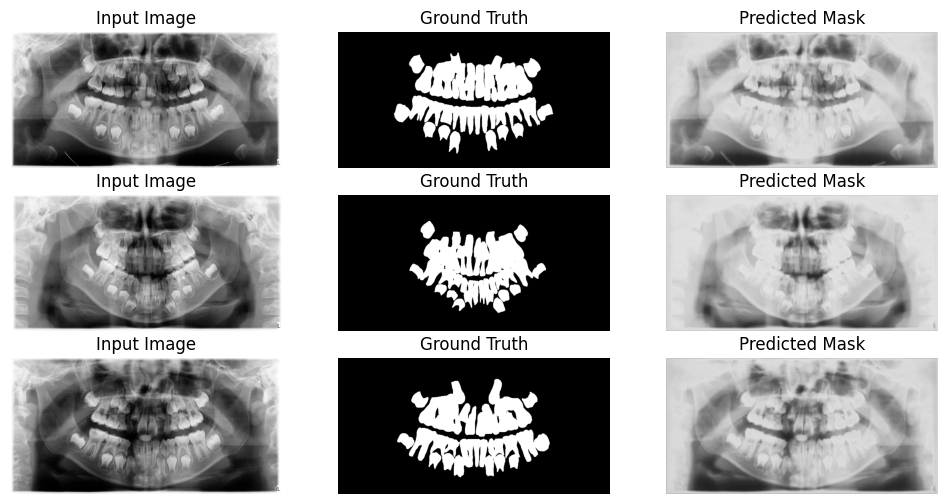

Epoch/Epochs: 200/2000
discriminator loss: [tag: 0.7287238836288452], generator loss: [tag: [8.437858581542969, 0.852974534034729, 0.07584884017705917, 0.852974534034729, 0.3402882516384125]]


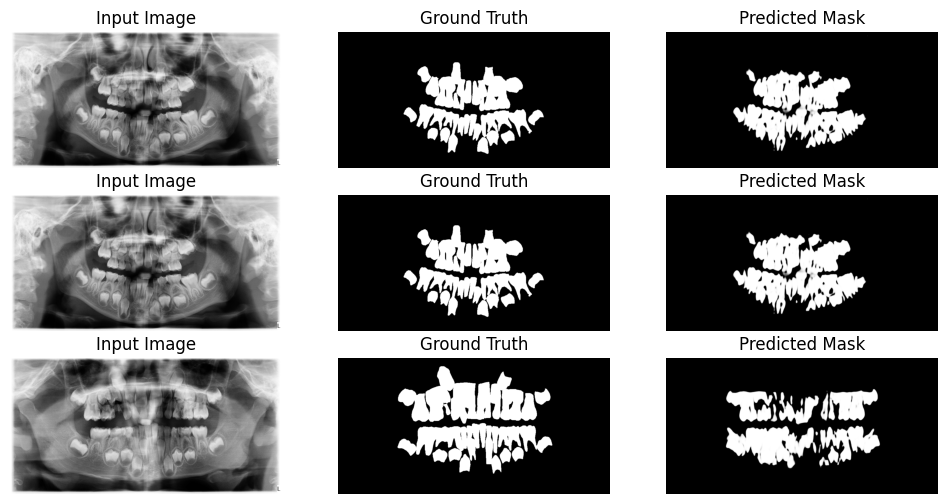

Epoch/Epochs: 400/2000
discriminator loss: [tag: 0.658058226108551], generator loss: [tag: [4.128850936889648, 0.49082908034324646, 0.03638022020459175, 0.49082908034324646, 0.5276368856430054]]


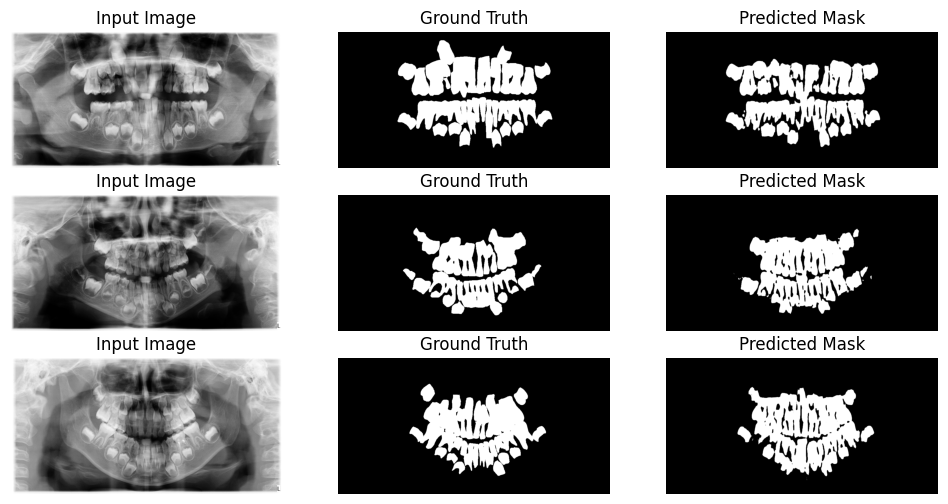

Epoch/Epochs: 600/2000
discriminator loss: [tag: 0.6951596736907959], generator loss: [tag: [4.3243727684021, 1.270821213722229, 0.030535515397787094, 1.270821213722229, 0.5196061134338379]]


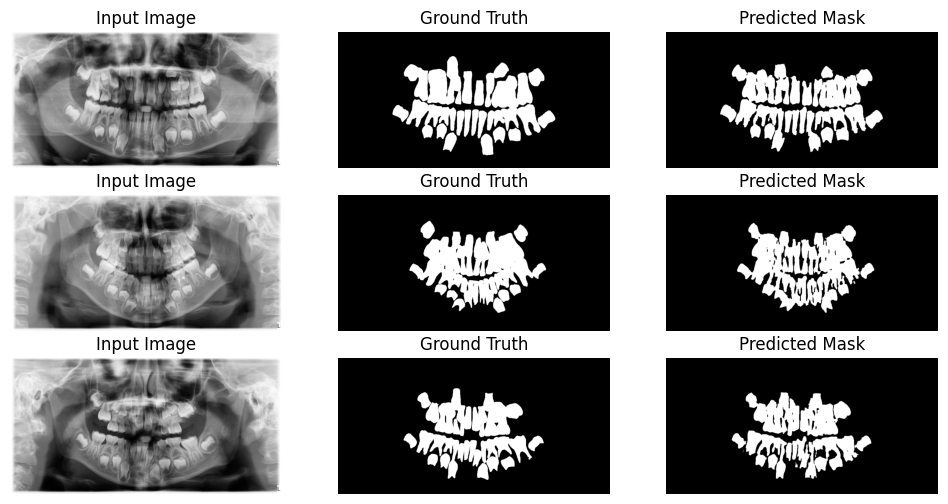

Epoch/Epochs: 800/2000
discriminator loss: [tag: 0.6344876289367676], generator loss: [tag: [3.683140277862549, 0.911889910697937, 0.02771250158548355, 0.911889910697937, 0.6740735769271851]]


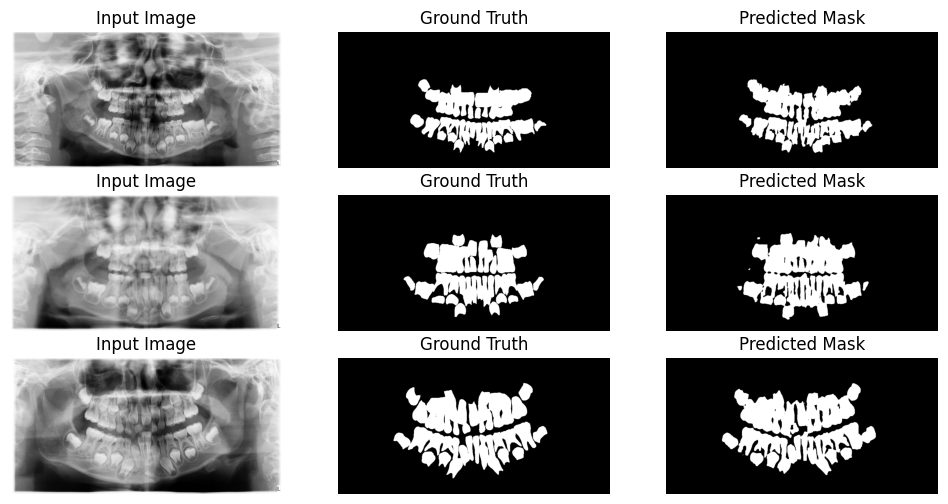

Epoch/Epochs: 1000/2000
discriminator loss: [tag: 0.7150169610977173], generator loss: [tag: [3.4577126502990723, 0.5003031492233276, 0.029574094340205193, 0.5003031492233276, 0.721899151802063]]


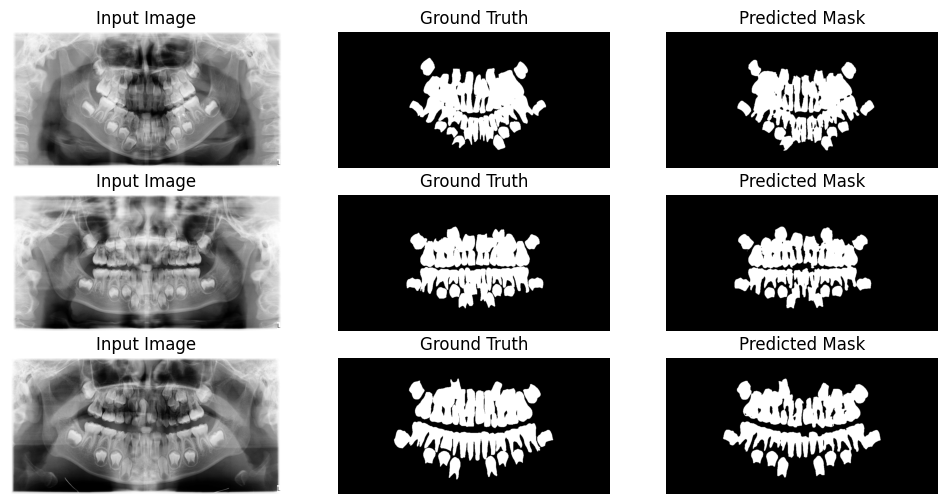

Epoch/Epochs: 1200/2000
discriminator loss: [tag: 0.6715452671051025], generator loss: [tag: [3.075505495071411, 0.5217781066894531, 0.025537272915244102, 0.5217781066894531, 1.1716337203979492]]


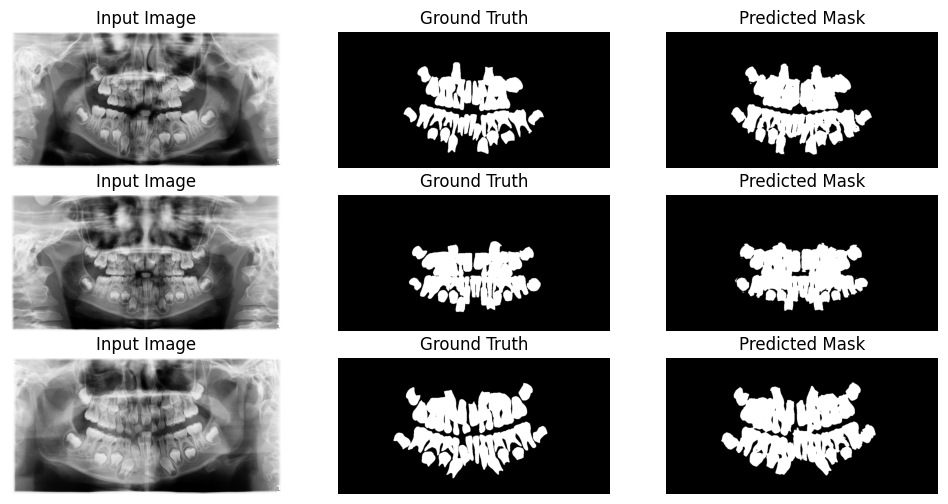

Epoch/Epochs: 1400/2000
discriminator loss: [tag: 0.6206571459770203], generator loss: [tag: [3.5034193992614746, 0.8812485933303833, 0.026221707463264465, 0.8812485933303833, 1.2291418313980103]]


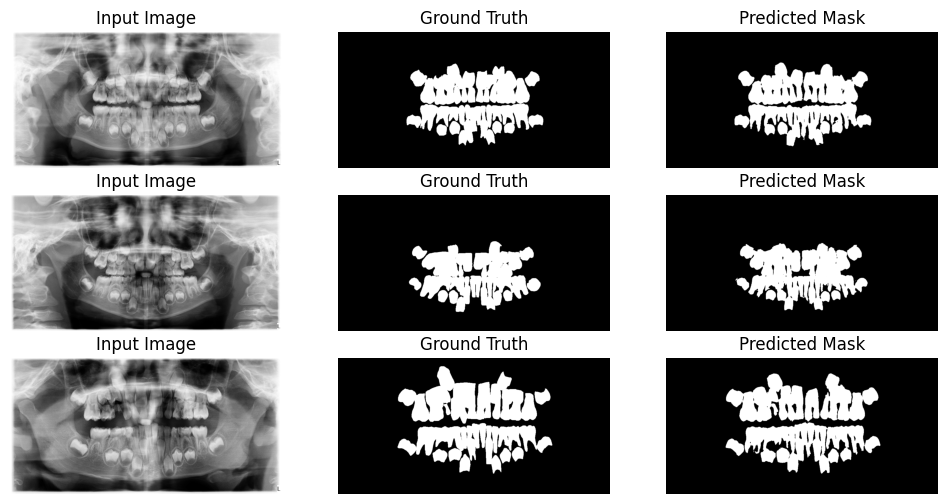

Epoch/Epochs: 1600/2000
discriminator loss: [tag: 0.6539685726165771], generator loss: [tag: [3.4254209995269775, 1.0121119022369385, 0.024133089929819107, 1.0121119022369385, 1.5669442415237427]]


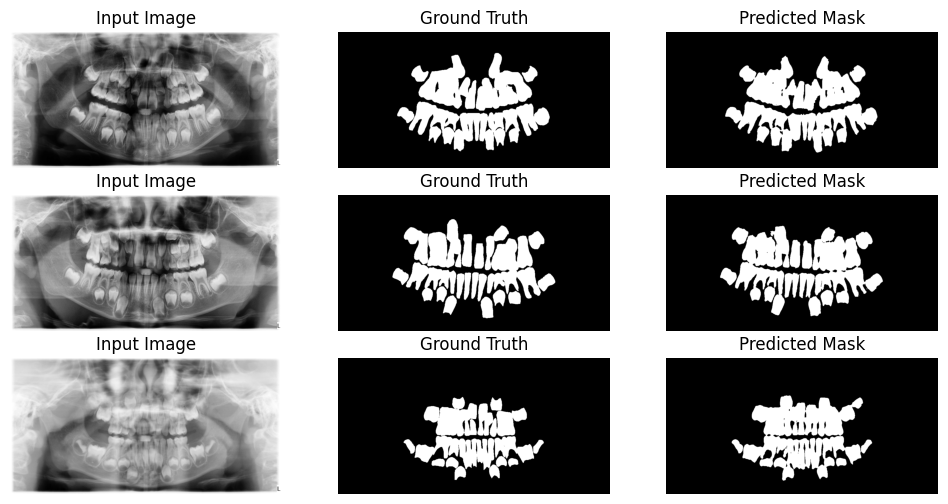

Epoch/Epochs: 1800/2000
discriminator loss: [tag: 0.7178674936294556], generator loss: [tag: [4.066699504852295, 1.0542365312576294, 0.03012463077902794, 1.0542365312576294, 2.2525408267974854]]


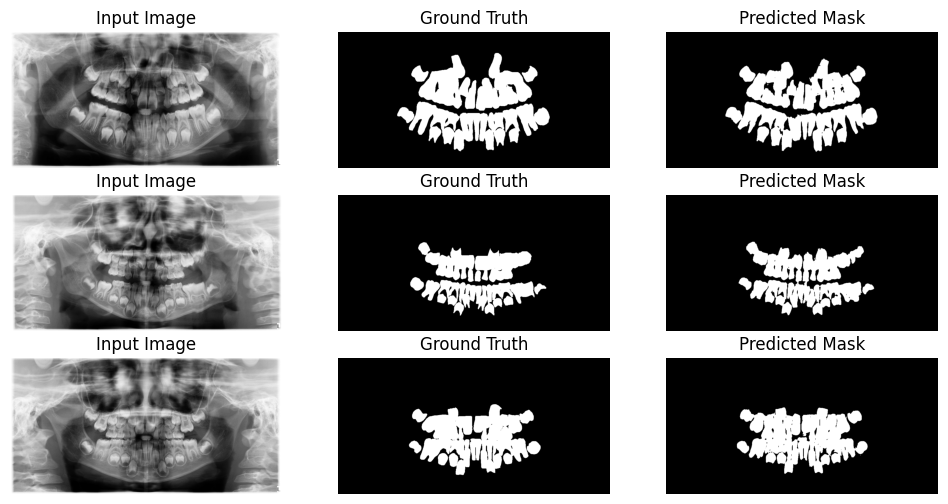

Epoch/Epochs: 1999/2000
discriminator loss: [tag: 0.6594749093055725], generator loss: [tag: [3.4651875495910645, 0.8044792413711548, 0.026607083156704903, 0.8044792413711548, 2.554790735244751]]


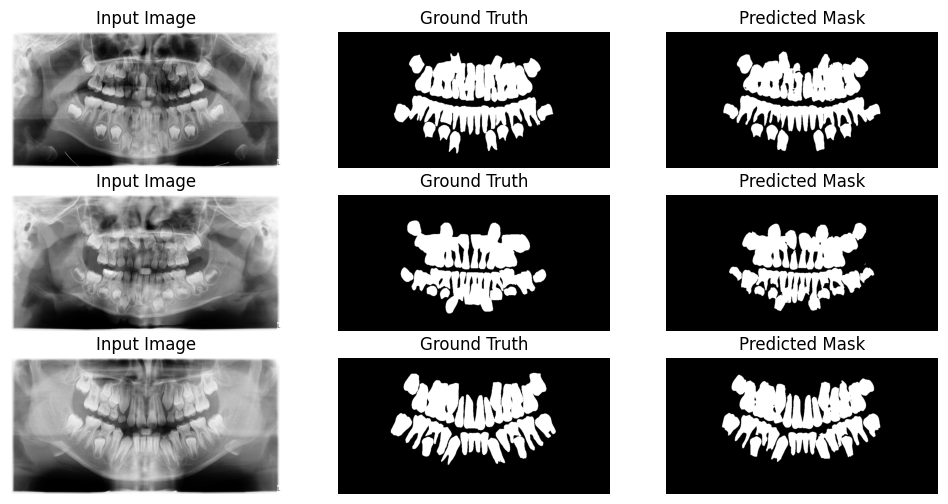

time: 55min 2s (started: 2024-12-02 12:29:51 +00:00)


In [23]:
dlossTagList = []
glossTagList = []

for epoch in range(EPOCHS):
    indexs = np.random.randint(0, len(trainImages), size = (BATCH, ))
    realImages = trainImages[indexs]
    realMasks = trainMasks[indexs]
    realTag = tf.ones(shape = (BATCH, ))
    
    fakeMasks = generator.predict([realImages], verbose=0)  
    fakeTag = tf.zeros(shape = (BATCH, ))
    
    allTags = np.hstack([realTag, fakeTag])
    allMasks = np.vstack([realMasks, fakeMasks])
    allImages = np.vstack([realImages, realImages])
    
    dlossTag = discriminator.train_on_batch([allMasks, allImages], [allTags])
    glossTag = gan.train_on_batch([realMasks, realImages], [realTag, realMasks])
    
    dlossTagList.append(dlossTag)
    glossTagList.append(glossTag) 
    if epoch % 200 == 0 or epoch == EPOCHS-1:
        print(f"Epoch/Epochs: {epoch}/{EPOCHS}")
        print(f"discriminator loss: [tag: {dlossTag}], generator loss: [tag: {glossTag}]")
        validIndexs = np.random.randint(0, len(validImages), size = (3, ))
        samples(generator, validImages[validIndexs], validMasks[validIndexs])

min mae index-: 1947
min mae: -0.1548
last mae: 0.9104


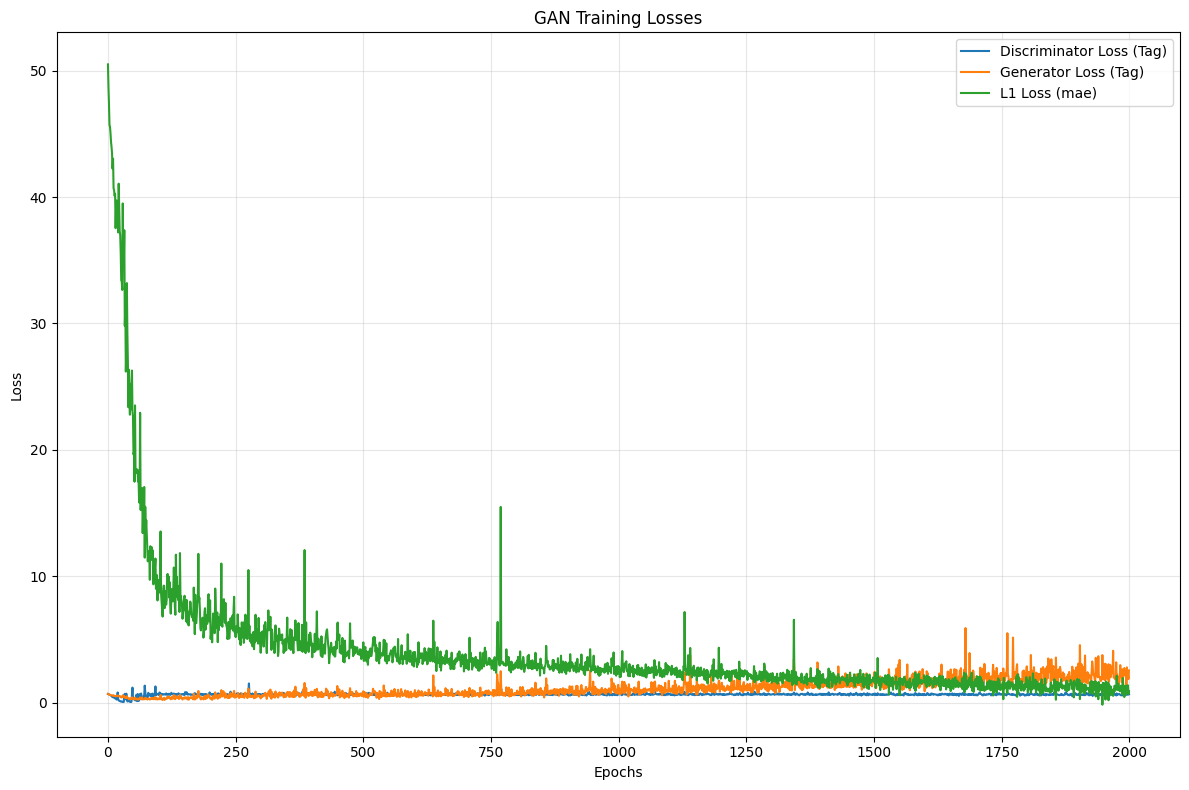

time: 690 ms (started: 2024-12-02 14:29:50 +00:00)


In [32]:
df = pd.DataFrame(glossTagList, columns=["loss 1", "loss 2", "loss 3", "loss 4", "loss 5"])
df['loss 1'] = df['loss 1'] - df['loss 5']
print(f"min mae index-: {df['loss 1'].idxmin()}")
print(f"min mae: {round(np.min(df['loss 1']),4)}")
print(f"last mae: {round(df['loss 1'].iloc[-1],4)}")

plt.figure(figsize=(12, 8))
plt.plot(dlossTagList, label='Discriminator Loss (Tag)')
plt.plot(df['loss 5'], label='Generator Loss BCE (Tag)')
plt.plot(df['loss 1'], label='L1 Loss (mae)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.legend()
plt.savefig(os.path.join(plot_path, 'first_training_loss_1.png'), dpi=300)
plt.show()

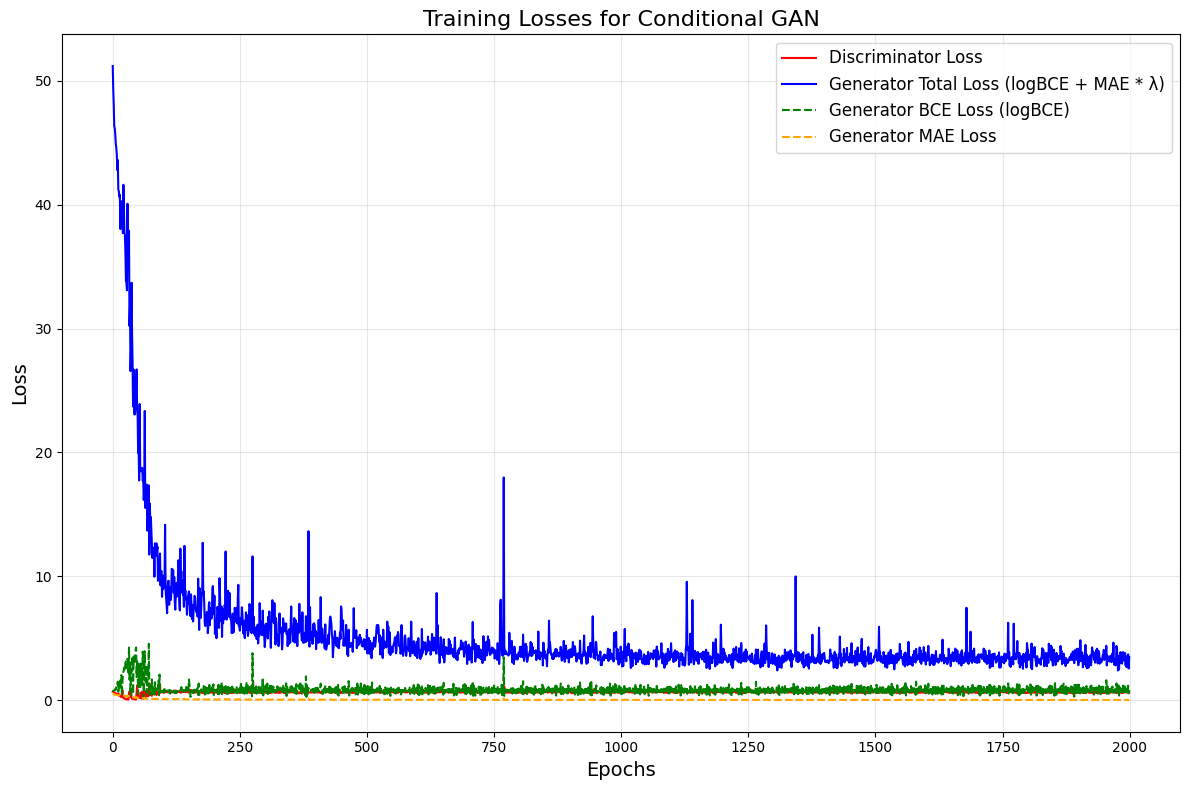

time: 1.03 s (started: 2024-12-02 14:29:50 +00:00)


In [33]:
# Extract specific losses from glossTagList
epochs = np.arange(len(dlossTagList))

# Discriminator loss
discriminator_loss = [dloss for dloss in dlossTagList]

# Generator losses
generator_total_loss = [gloss[0] for gloss in glossTagList]  # Total generator loss
generator_bce_loss = [gloss[4] for gloss in glossTagList]   # BCE loss
generator_mae_loss = [gloss[2] for gloss in glossTagList]   # MAE loss

# Plotting
plt.figure(figsize=(12, 8))

# Plot Discriminator loss
plt.plot(epochs, discriminator_loss, label="Discriminator Loss", color='red', linewidth=1.5)

# Plot Generator total loss
plt.plot(epochs, generator_total_loss, label="Generator Total Loss (logBCE + MAE * λ)", color='blue', linewidth=1.5)

# Plot Generator BCE loss
plt.plot(epochs, generator_bce_loss, label="Generator BCE Loss (logBCE)", color='green', linestyle='--', linewidth=1.5)

# Plot Generator MAE loss
plt.plot(epochs, generator_mae_loss, label="Generator MAE Loss", color='orange', linestyle='--', linewidth=1.5)
# Customize plot
plt.title("Training Losses for Conditional GAN", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Save and show plot
plt.tight_layout()
plt.savefig(os.path.join(plot_path, 'first_training_loss_2.png'), dpi=300)
plt.show()


Discriminator Loss: Mean = 0.6646, Std = 0.0477
Generator Total Loss: Mean = 3.6793, Std = 0.7968
Generator BCE Loss: Mean = 0.8154, Std = 0.2364
Generator MAE Loss: Mean = 0.0286, Std = 0.0073


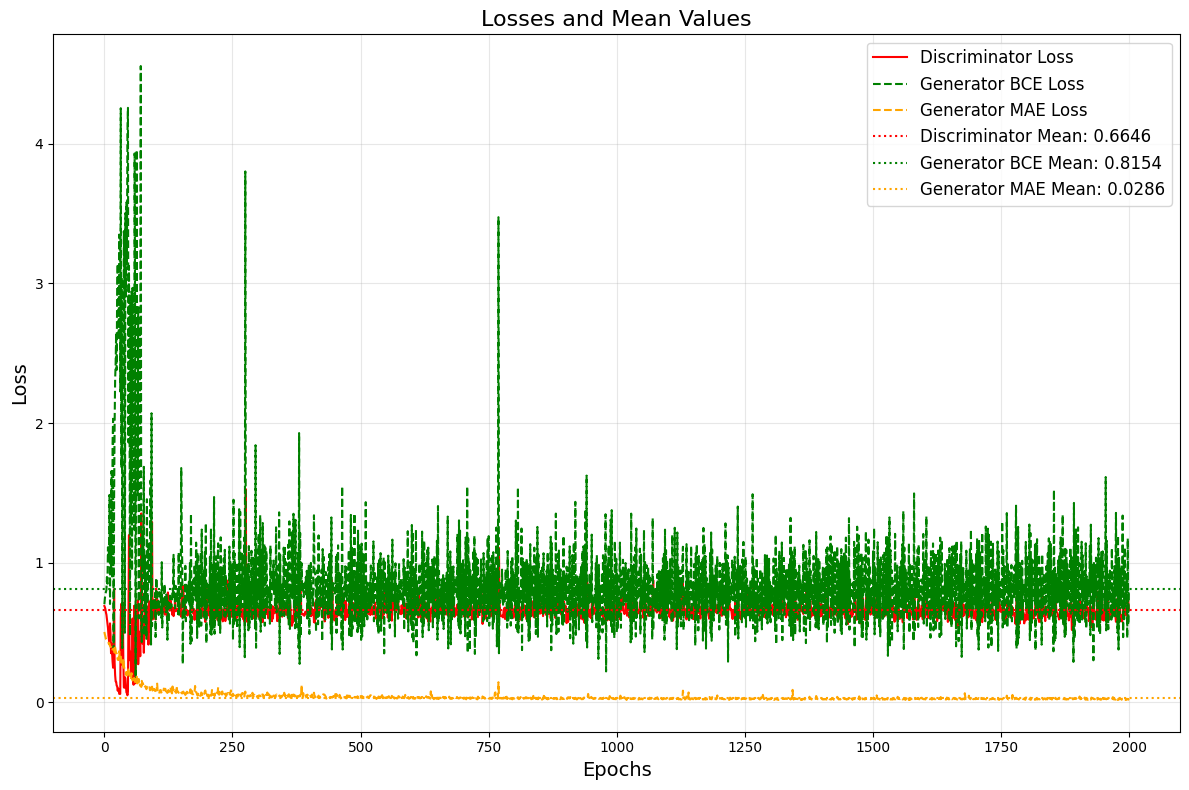

time: 769 ms (started: 2024-12-02 14:29:52 +00:00)


In [34]:
# Define stable range (e.g., from epoch 500 onward)
stable_start = 500
stable_end = len(epochs)

# Extract stable region losses
stable_dloss = dlossTagList[stable_start:stable_end]
stable_gloss = glossTagList[stable_start:stable_end]

# Generator losses
stable_total_loss = [gloss[0] for gloss in stable_gloss]
stable_bce_loss = [gloss[1] for gloss in stable_gloss]
stable_mae_loss = [gloss[2] for gloss in stable_gloss]

# Calculate mean and standard deviation
dloss_mean, dloss_std = np.mean(stable_dloss), np.std(stable_dloss)
total_mean, total_std = np.mean(stable_total_loss), np.std(stable_total_loss)
bce_mean, bce_std = np.mean(stable_bce_loss), np.std(stable_bce_loss)
mae_mean, mae_std = np.mean(stable_mae_loss), np.std(stable_mae_loss)

# Print results
print(f"Discriminator Loss: Mean = {dloss_mean:.4f}, Std = {dloss_std:.4f}")
print(f"Generator Total Loss: Mean = {total_mean:.4f}, Std = {total_std:.4f}")
print(f"Generator BCE Loss: Mean = {bce_mean:.4f}, Std = {bce_std:.4f}")
print(f"Generator MAE Loss: Mean = {mae_mean:.4f}, Std = {mae_std:.4f}")

# Optional: Add horizontal lines to the plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Plot losses
plt.plot(epochs, dlossTagList, label="Discriminator Loss", color='red', linewidth=1.5)
plt.plot(epochs, [gloss[1] for gloss in glossTagList], label="Generator BCE Loss", color='green', linestyle='--', linewidth=1.5)
plt.plot(epochs, [gloss[2] for gloss in glossTagList], label="Generator MAE Loss", color='orange', linestyle='--', linewidth=1.5)

# Add horizontal lines for means
plt.axhline(dloss_mean, color='red', linestyle=':', label=f"Discriminator Mean: {dloss_mean:.4f}")
plt.axhline(bce_mean, color='green', linestyle=':', label=f"Generator BCE Mean: {bce_mean:.4f}")
plt.axhline(mae_mean, color='orange', linestyle=':', label=f"Generator MAE Mean: {mae_mean:.4f}")

# Customize plot
plt.title("Losses and Mean Values", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(plot_path, 'first_training_loss_3.png'), dpi=300)
plt.show()

In [39]:
generator_saved = f'1024_5block_RMSprop_swish+leakyrelu_CGAN_{EPOCHS}_clahe_generator.h5'
discriminator_saved = f'1024_5block_RMSprop_swish+leakyrelu_CGAN_{EPOCHS}_clahe_discriminator.h5'

generator_path = os.path.join(model_path, generator_saved)
discriminator_path = os.path.join(model_path, discriminator_saved)

# generator.save_weights(generator_path)
# discriminator.save_weights(discriminator_path)

# - Now we will train the generator again with a number of layers frozen in order to maintain the capacity that the generator has gained.

time: 448 µs (started: 2024-12-02 15:49:11 +00:00)


In [40]:
weight_path = generator_path

generator2 = generator(input=layers.Input(shape=IMAGE_SHAPE), filter=32, padding='same', kernel=3, strides=1, 
                             model_weights=True, weights_path=weight_path)

for layer in generator2.layers[:20]:
    layer.trainable = False
    
optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5, weight_decay=1e-7)
generator2.compile(loss=bce_dice_loss,
                         optimizer=optimizer, 
                         metrics=[tf.keras.metrics.Precision(name = 'precision'),
                                  tf.keras.metrics.Recall(name = 'recall'), 
                                  tf.keras.metrics.BinaryIoU(name = 'IoU'),
                                  dice_score,
                                  tf.keras.metrics.BinaryCrossentropy(name='logBCE', from_logits=True),
                                  tf.keras.metrics.MeanAbsoluteError(name='MAE')])

2024-12-02 15:49:11.994661: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-02 15:49:11.994908: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-02 15:49:11.995002: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 1024, 1)]       0         []                            
                                                                                                  
 encoder1_conv1 (Conv2D)     (None, 512, 1024, 32)        288       ['input_1[0][0]']             
                                                                                                  
 encoder1_gn1 (GroupNormali  (None, 512, 1024, 32)        64        ['encoder1_conv1[0][0]']      
 zation)                                                                                          
                                                                                                  
 encoder1_conv4 (Conv2D)     (None, 512, 1024, 32)        64        ['input_1[0][0]']     

# Evaluate the generator model

In [41]:
generator2.evaluate(validImages, validMasks, batch_size=8)

/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-12-02 15:49:26.160447: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


time: 28.2 s (started: 2024-12-02 15:49:22 +00:00)



KeyboardInterrupt



In [ ]:
generator2.evaluate(testImages, testMasks, batch_size=8)

In [ ]:
def draw(images, masks, y_pred):
    plt.figure(figsize = (12, 24))
    index = -1
    n = np.random.randint(y_pred.shape[0])
    for i in range(120):
        plt.subplot(20, 6, (i + 1))
        if index == -1:
            plt.imshow(images[n], cmap = 'gray')
            plt.title('Image')
            plt.axis('off')
            index = 0
        elif index == 0:
            plt.imshow(images[n], cmap = 'gray')
            plt.imshow(masks[n], alpha = 0.6, cmap = 'gray')
            plt.title('Original Mask')
            plt.axis('off')
            index = 1
        elif index == 1:
            plt.imshow(images[n], cmap = 'gray')
            plt.imshow(np.reshape(y_pred[n], IMAGE_SHAPE[:2]), alpha = 0.6, cmap = 'gray')
            plt.title('Predict Mask')
            plt.axis('off')
            index = -1
            n = np.random.randint(y_pred.shape[0])
    plt.legend()

In [ ]:
masks_pred = generator2.predict(validImages, verbose=0, batch_size=8)
masks_pred = (masks_pred >= 0.5).astype('int')
masks_pred.shape
draw(validImages, validMasks, masks_pred)

# Re-training of the generator according to the pixel2pixel methodology

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,           # Reduce the learning rate by a factor of 0.2
    patience=3,           # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,
    mode='min',
    min_delta=1e-4,       # minimum changed in monitor metrics
)

history = generator2.fit(trainImages, trainMasks, epochs=200, batch_size=4,
                               validation_data=(validImages, validMasks), verbose=2, 
                               callbacks=[early_stopping, reduce_lr])

# The results obtained

In [ ]:
metrics = ['loss', 'precision', 'recall', 'IoU', 'dice_score', 'log BCE loss', 'MAE loss']
plt.figure(figsize = (15, 9))
for i in range(5):
    plt.subplot(2, 3, (i + 1))
    plt.plot(history.history['{}'.format(metrics[i])], label = '{}'.format(metrics[i]))
    plt.plot(history.history['val_{}'.format(metrics[i])], label = 'val_{}'.format(metrics[i]))
    plt.title('{}'.format(metrics[i]))
    plt.legend()
plt.savefig('/notebooks/chart/secondtrain_history_chart_1.png')

In [ ]:
metrics = ['loss', 'precision', 'recall', 'IoU', 'dice_score', 'log BCE loss', 'MAE loss']
plt.figure(figsize = (12, 8))
for i in range(4):
    plt.subplot(2, 2, (i + 1))
    plt.plot(history.history['{}'.format(metrics[i])], label = '{}'.format(metrics[i]))
    plt.plot(history.history['val_{}'.format(metrics[i])], label = 'val_{}'.format(metrics[i]))
    plt.title('{}'.format(metrics[i]))
    plt.legend()
plt.savefig('/notebooks/chart/secondtrain_history_chart_2.png')

In [ ]:
generator2.evaluate(validImages, validMasks, batch_size=8)

In [ ]:
generator2.evaluate(testImages, testMasks, batch_size=8)

In [ ]:
generator_path2 = os.path.join(model_path, 'final', f'final_{generator_saved}')
generator2.save(generator_path2)

In [ ]:
generator3 = tf.keras.models.load_model(generator_path2,  
                                        custom_objects={'bce_dice_loss':bce_dice_loss,
                                                        'dice_score': dice_score})

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predIdxs = generator3.predict(validImages, batch_size=8)
predIdxs = (predIdxs >= 0.5).astype('int')

validMasks_flat = validMasks.flatten()
predIdxs_flat = predIdxs.flatten()

print("validMasks shape:", validMasks_flat.shape)
print("predIdxs shape:", predIdxs_flat.shape)

class_names = ["Object", "Background"]

print(classification_report(
    validMasks_flat, predIdxs_flat,
    target_names=class_names
))

conf_mat = confusion_matrix(validMasks_flat, predIdxs_flat)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
plt.savefig('/notebooks/chart/secondtrain_confusion_matrix.png')

In [ ]:
masks_pred = generator3.predict(validImages, verbose=0, batch_size=8)
masks_pred = (masks_pred >= 0.5).astype('int')
print(masks_pred.shape)
draw(validImages, validMasks, masks_pred)

In [ ]:
masks_pred = generator3.predict(testImages, verbose=0, batch_size=8)
masks_pred = (masks_pred >= 0.5).astype('int')
print(masks_pred.shape)
draw(testImages, testMasks, masks_pred)

In [ ]:
masks_pred = generator3.predict(trainImages, verbose=0, batch_size=8)
masks_pred = (masks_pred >= 0.5).astype('int')
print(masks_pred.shape)
draw(trainImages, trainMasks, masks_pred)

In [ ]:
import zipfile,os
folder_to_zip = os.path.join(os.getcwd(),'chart')
zip_file_name =  os.path.splitext(generator_saved)[0].replace("_generator", "") + '.zip'
with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for foldername, subfolders, filenames in os.walk(folder_to_zip):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            arcname = os.path.relpath(file_path, folder_to_zip)
            zipf.write(file_path, arcname)
zipf.close()

print(f"{zip_file_name} success zipping...")